 # Trapazoidal motion profile generation
 
 Generate a motion profile (sequence of positions and velocities from point A to point B) with a few constraints:
  - speed may not exceed a specified maximum
  - acceleration may not exceed a specified maximum
  - the path must a continuous function
  - integrating velocity must yield position 

In [1]:
%%javascript
IPython.OutputArea.prototype._should_scroll = function(lines) {
    return false;
}

<IPython.core.display.Javascript object>

In [2]:
from collections import namedtuple

ProfileParams = namedtuple("ProfileParams",
                           ["distance", "angle", "max_velocity",
                            "max_acceleration", "halt", "rampup"])
# halt specified whether we slow down to zero velocity at the end
# rampup specifies whether we start with zero velocity at the beginning

Waypoint = namedtuple("Waypoint",
                      ["time", "linear_velocity", "linear_dist",
                       "angular_velocity", "angular_dist", "done"])

def assert_near(a, b, tolerance=0.01):
    #print(a, b, tolerance)
    assert abs(a - b) < abs(tolerance), (a, b, tolerance)

In [3]:
import math

def signum(x):
    if x < 0:
        return -1
    elif x == 0:
        return 0
    else:
        return 1
    
class ImpossibleProfileException(Exception):
    pass

def gen_profile(params):
    dist, angle, v_max, a_max, halt, rampup = params
    """
    Generate a motion profile that should approach (dist, angle)
    without exceeding a maximum velocity or acceleration
    """
    t_0 = 0.0
    dist_ramp = 0.5 * v_max * (v_max / a_max) * signum(dist) # upper bound on distance we could travel while accelerating
    
    print("rampup dist: ", dist_ramp)
    
    if rampup:
        if halt:
            if abs(2 * dist_ramp) < abs(dist):
                # the move is long enough to get up to speed
                t_1 = v_max / a_max
                dist_during_const_vel = dist - (2 * dist_ramp)
                t_2 = abs(dist_during_const_vel) / v_max + t_1
                t_3 = t_2 + t_1
            else:
                # the move is not long enough so speed up then slow down (triangular profile)
                t_1 = math.sqrt(abs(dist / a_max))
                t_2 = t_1
                t_3 = 2.0 * t_1
        else:
            if abs(dist_ramp) < abs(dist):
                # the move is long enough to get up to speed
                t_1 = v_max / a_max
                dist_during_const_vel = dist - dist_ramp
                t_2 = abs(dist_during_const_vel) / v_max + t_1
                t_3 = t_2
            else:
                # we will still be speeding up when we get to the setpoint
                t_1 = math.sqrt(abs(2 * dist / a_max))
                t_2 = t_1
                t_3 = t_1
    else:
        if halt:
            if abs(dist_ramp) > abs(dist):
                raise ImpossibleProfileException("%f > %f" % (abs(dist_ramp), abs(dist)))
            # We will be at velocity then slowing down for some time
            t_1 = 0.0
            dist_during_const_vel = dist - dist_ramp
            t_2 = abs(dist_during_const_vel) / v_max
            t_3 = t_2 + v_max / a_max
        else:
            # we will be going constant velocity the entire time (boring profile)
            t_1 = 0.0
            t_2 = abs(dist / v_max)
            t_3 = t_2
    
    print(t_0, t_1, t_2, t_3)
        
    def ret(t):
        """
        Given an input time |t|:
        if t < t_0:
            we are pre move (somehow?).  Return a zero goal
        if t_0 < t < t_1
            we are in the constant acceleration portion.  Return an accelerating goal
        if t_1 < t < t_2
            we are in the constant velocity portion.  Return a constant velocity goal
        if t_2 < t < t_3
            we are in constant decceleration portion.  Return deccelerating goal
        if t_3 < t
            we are post move.  Return the end goal
        """
        
        if t < t_0: # pre-mortem
            return Waypoint(t, 0, 0, 0, 0, False)
        elif t_0 <= t < t_1: # ramp up
            velocity_now = a_max * t
            dist_now = 0.5 * t * velocity_now
            
            doneness = dist_now / dist * signum(dist) * signum(angle)
            angle_now = angle * doneness
            angle_vel_now = velocity_now * angle / dist * signum(dist) * signum(angle)
            return Waypoint(t,
                            velocity_now * signum(dist),
                            dist_now * signum(dist),
                            angle_vel_now * signum(angle),
                            angle_now * signum(angle),
                            False)
        elif t_1 <= t < t_2: # coast
            velocity_now = v_max
            time_in_phase = t - t_1
            dist_in_phase = time_in_phase * velocity_now
            if rampup:
                dist_now = abs(dist_ramp) + dist_in_phase
            else:
                dist_now = dist_in_phase
            
            doneness = dist_now / dist * signum(dist) * signum(angle)
            angle_now = angle * doneness
            angle_vel_now = velocity_now * angle / dist * signum(dist) * signum(angle)
            return Waypoint(t,
                            velocity_now * signum(dist),
                            dist_now * signum(dist),
                            angle_vel_now * signum(angle),
                            angle_now * signum(angle),
                            False)
        elif t_2 <= t < t_3: # halt
            time_till_end = t_3 - t
            velocity_now = a_max * time_till_end
            dist_till_end = 0.5 * time_till_end * velocity_now
            dist_now = abs(dist) - dist_till_end
            
            doneness = dist_now / dist * signum(dist) * signum(angle)
            angle_now = angle * doneness
            angle_vel_now = velocity_now * angle / dist * signum(dist) * signum(angle)
            return Waypoint(t,
                            velocity_now * signum(dist),
                            dist_now * signum(dist),
                            angle_vel_now * signum(angle),
                            angle_now * signum(angle),
                            False)
        elif t_3 <= t: # post-mortem
            if halt:
                return Waypoint(t, 0, dist, 0, angle, True)
            else:
                if rampup:
                    velocity_now = min(v_max, a_max * t_3)
                else:
                    velocity_now = v_max
                angle_vel_now = velocity_now * angle / dist * signum(dist) * signum(angle)
                print(velocity_now)
                return Waypoint(t,
                                velocity_now * signum(dist),
                                dist,
                                angle_vel_now * signum(angle),
                                angle,
                                True)
        else:
            raise Exception("bamboozled again")
    return ret

In [8]:
%matplotlib inline

import numpy as np
import matplotlib.pyplot as plt
import csv, os

def graph_profile(points):
    """
    Plot the points in the given profile.  (velocities on top and positions on bottom)
    """
    times = [x.time for x in points]
    lin_vels = [x.linear_velocity for x in points]
    lin_dsts = [x.linear_dist for x in points]
    ang_vels = [x.angular_velocity for x in points]
    ang_dsts = [x.angular_dist for x in points]
    
    plt.subplot(2, 1, 1)
    plt.title('Linear and Angular velocity over time (trapazoidal)')
    plt.plot(times, lin_vels, 'o-', label="linear")
    plt.plot(times, ang_vels, 'o-', label="angular")
    plt.ylabel('Velocity (in/sec and deg/sec)')
    plt.subplot(2, 1, 2)
    plt.title('Linear and Angular distance over time')
    plt.plot(times, lin_dsts, 'o-', label="linear")
    plt.plot(times, ang_dsts, 'o-', label="angular")
    plt.ylabel('Position (in an deg)')
    plt.xlabel('Time (sec)')

    plt.tight_layout()
    plt.show()
    
def assert_vel_integral(points, params):
    """
    Assume constant timestep
    Assert that the integral of velocity is about equal to the distance at every step
    """
    timestep = points[1].time - points[0].time
    dist_integral = 0.0
    angle_integral = 0.0
    prev = points[0]
    for point in points:
        #print(point)
        dist_integral += (point.linear_velocity + prev.linear_velocity) / 2.0 * timestep
        angle_integral += (point.angular_velocity + prev.angular_velocity) / 2.0 * timestep
        
        tolerance = 2.0 * timestep * params.max_velocity + 0.001
        assert_near(angle_integral, point.angular_dist, tolerance)
        assert_near(dist_integral, point.linear_dist, tolerance)
        prev = point

def assert_dist_range(points, params):
    """
    Assert that the beginning and end of the profile are as expected (does it get there ever?)
    """
    assert points[0].linear_dist == 0
    assert points[0].angular_dist == 0
    assert points[-1].linear_dist == params.distance
    assert points[-1].angular_dist == params.angle
    
    if params.halt:
        assert points[-1].linear_velocity == 0
        assert points[-1].angular_velocity == 0
    else:
        assert points[-1].linear_velocity != 0
        if params.angle != 0.0:
            assert points[-1].angular_velocity != 0

def assert_v_a_constraints(points, params):
    """
    Assert that at no point velocity exceeds maximum velocity
    and that at no point acceleration exceeds maximum acceleration
    """
    prev = points[0]
    for point in points:
        assert(abs(point.linear_velocity) <= abs(params.max_velocity))
        assert(abs(point.linear_velocity - prev.linear_velocity) <= abs(params.max_acceleration))
        prev = point
        
def test_gen_profile(params, timestep=0.05):
    """
    run through a profile with the given arguments
    and assert that it's a properly formed profile
    """
    generator = gen_profile(params)
    points = []
    time = 0
    while True:
        pt = generator(time)
        points.append(pt)
        if pt.done:
            break
        time += timestep
    
    graph_profile(points)
    assert_vel_integral(points, params)
    assert_dist_range(points, params)
    assert_v_a_constraints(points, params)

def assert_profile_impossible(params):
    """
    Assert that this profile is, in fact, impossible to follow given the constraints
    """
    if params.rampup is False and params.halt is True:
        ramp_dist = 0.5 * params.max_velocity * (params.max_velocity / params.max_acceleration)
        assert ramp_dist > abs(params.distance), ("profile is possible ramp: %f total: %f" %
                                                  (ramp_dist, abs(params.dist)))

Linear distance is Positive
Angle is Positive
Acceleration max is 3
Max velocity is 5
Will halt at end of profile
Will start with zero velocity
ProfileParams(distance=40, angle=10, max_velocity=5, max_acceleration=3, halt=True, rampup=True)
rampup dist:  4.166666666666667
0.0 1.6666666666666667 8.0 9.666666666666666


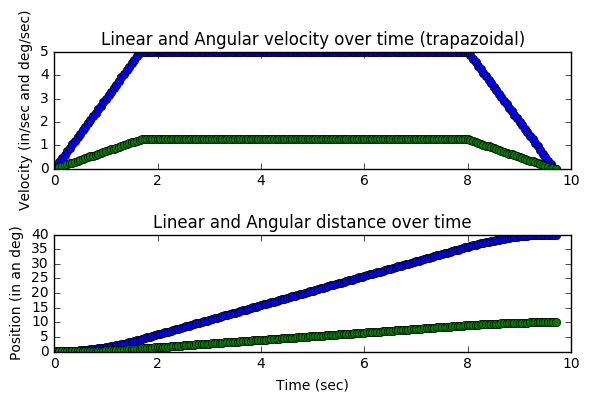







Linear distance is Negative
Angle is Negative
Acceleration max is 3
Max velocity is 5
Will halt at end of profile
Will start with zero velocity
ProfileParams(distance=-40, angle=10, max_velocity=5, max_acceleration=3, halt=True, rampup=True)
rampup dist:  -4.166666666666667
0.0 1.6666666666666667 8.0 9.666666666666666


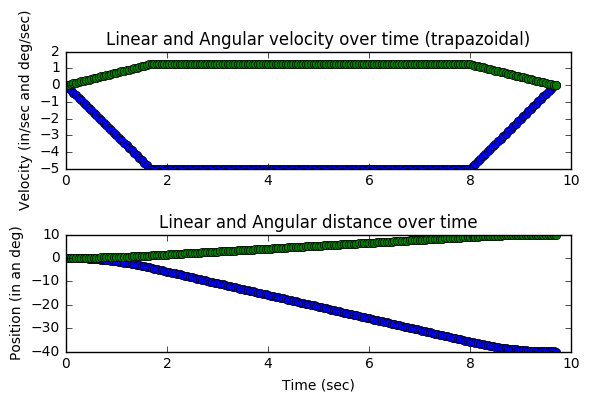







Linear distance is Positive
Angle is Positive
Acceleration max is 3
Max velocity is 5
Will halt at end of profile
Will start with zero velocity
ProfileParams(distance=40, angle=0, max_velocity=5, max_acceleration=3, halt=True, rampup=True)
rampup dist:  4.166666666666667
0.0 1.6666666666666667 8.0 9.666666666666666


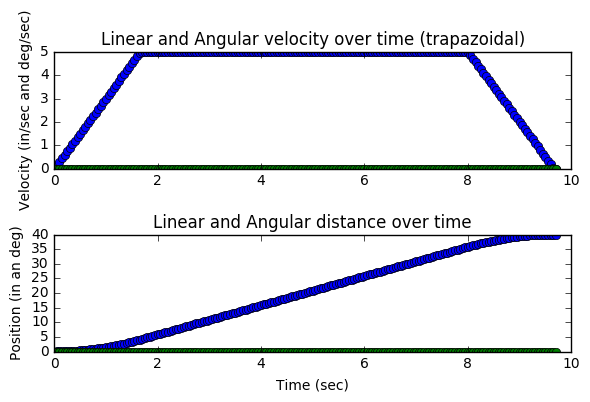







Linear distance is Negative
Angle is Negative
Acceleration max is 3
Max velocity is 5
Will halt at end of profile
Will start with zero velocity
ProfileParams(distance=-40, angle=0, max_velocity=5, max_acceleration=3, halt=True, rampup=True)
rampup dist:  -4.166666666666667
0.0 1.6666666666666667 8.0 9.666666666666666


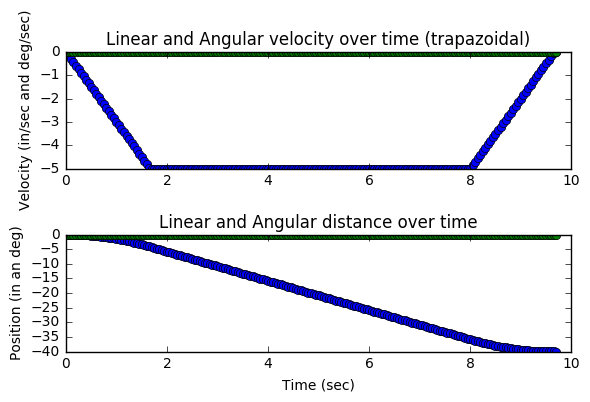







Linear distance is Positive
Angle is Positive
Acceleration max is 3
Max velocity is 5
Will halt at end of profile
Will start with zero velocity
ProfileParams(distance=40, angle=-10, max_velocity=5, max_acceleration=3, halt=True, rampup=True)
rampup dist:  4.166666666666667
0.0 1.6666666666666667 8.0 9.666666666666666


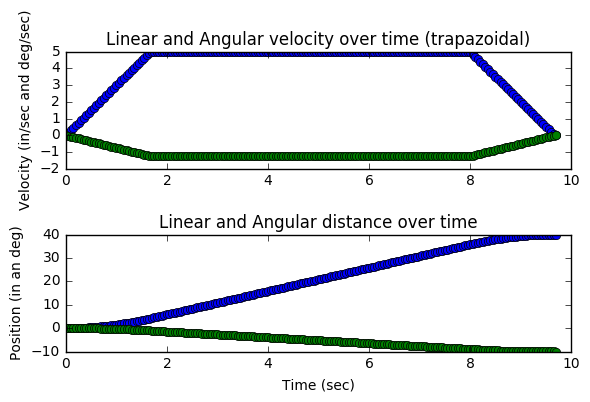







Linear distance is Negative
Angle is Negative
Acceleration max is 3
Max velocity is 5
Will halt at end of profile
Will start with zero velocity
ProfileParams(distance=-40, angle=-10, max_velocity=5, max_acceleration=3, halt=True, rampup=True)
rampup dist:  -4.166666666666667
0.0 1.6666666666666667 8.0 9.666666666666666


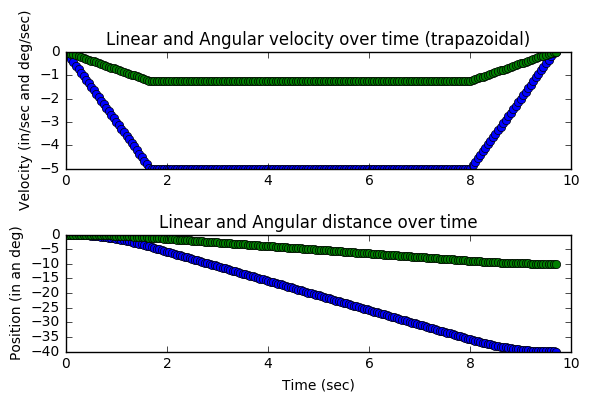







Linear distance is Positive
Angle is Positive
Acceleration max is 3
Max velocity is 50
Will halt at end of profile
Will start with zero velocity
ProfileParams(distance=40, angle=10, max_velocity=50, max_acceleration=3, halt=True, rampup=True)
rampup dist:  416.6666666666667
0.0 3.6514837167011076 3.6514837167011076 7.302967433402215


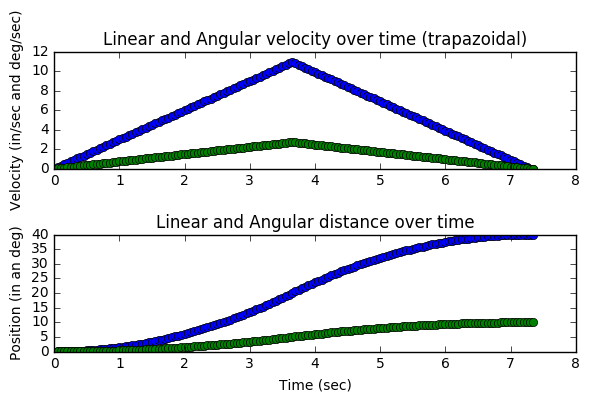







Linear distance is Negative
Angle is Negative
Acceleration max is 3
Max velocity is 50
Will halt at end of profile
Will start with zero velocity
ProfileParams(distance=-40, angle=10, max_velocity=50, max_acceleration=3, halt=True, rampup=True)
rampup dist:  -416.6666666666667
0.0 3.6514837167011076 3.6514837167011076 7.302967433402215


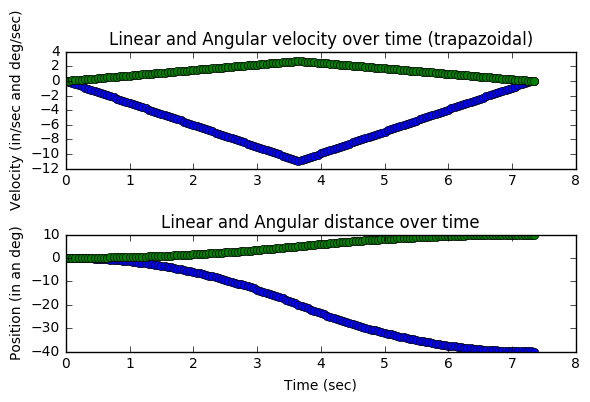







Linear distance is Positive
Angle is Positive
Acceleration max is 3
Max velocity is 50
Will halt at end of profile
Will start with zero velocity
ProfileParams(distance=40, angle=0, max_velocity=50, max_acceleration=3, halt=True, rampup=True)
rampup dist:  416.6666666666667
0.0 3.6514837167011076 3.6514837167011076 7.302967433402215


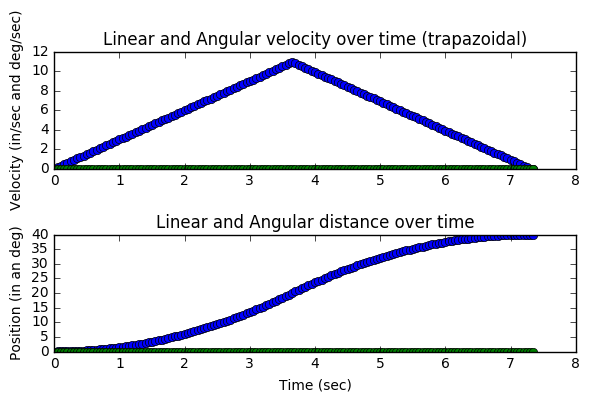







Linear distance is Negative
Angle is Negative
Acceleration max is 3
Max velocity is 50
Will halt at end of profile
Will start with zero velocity
ProfileParams(distance=-40, angle=0, max_velocity=50, max_acceleration=3, halt=True, rampup=True)
rampup dist:  -416.6666666666667
0.0 3.6514837167011076 3.6514837167011076 7.302967433402215


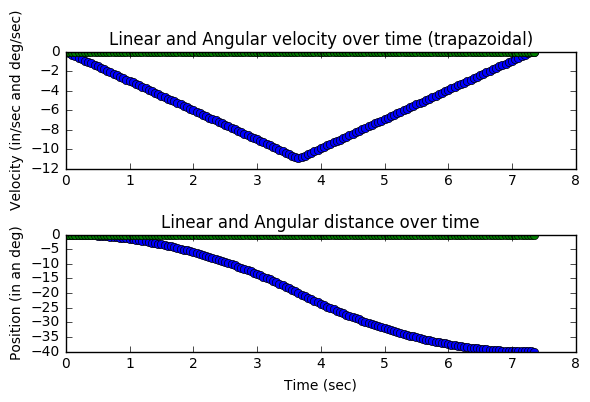







Linear distance is Positive
Angle is Positive
Acceleration max is 3
Max velocity is 50
Will halt at end of profile
Will start with zero velocity
ProfileParams(distance=40, angle=-10, max_velocity=50, max_acceleration=3, halt=True, rampup=True)
rampup dist:  416.6666666666667
0.0 3.6514837167011076 3.6514837167011076 7.302967433402215


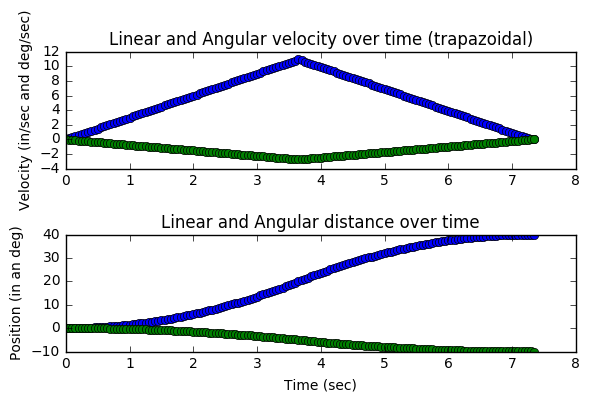







Linear distance is Negative
Angle is Negative
Acceleration max is 3
Max velocity is 50
Will halt at end of profile
Will start with zero velocity
ProfileParams(distance=-40, angle=-10, max_velocity=50, max_acceleration=3, halt=True, rampup=True)
rampup dist:  -416.6666666666667
0.0 3.6514837167011076 3.6514837167011076 7.302967433402215


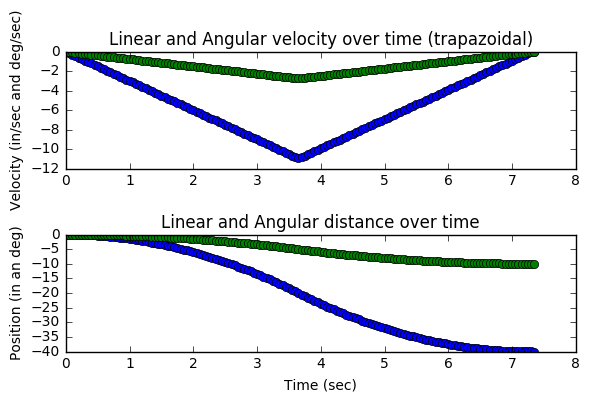







Linear distance is Positive
Angle is Positive
Acceleration max is 3
Max velocity is 5
Will not halt at end of profile
Will start with zero velocity
ProfileParams(distance=40, angle=10, max_velocity=5, max_acceleration=3, halt=False, rampup=True)
rampup dist:  4.166666666666667
0.0 1.6666666666666667 8.833333333333334 8.833333333333334
5


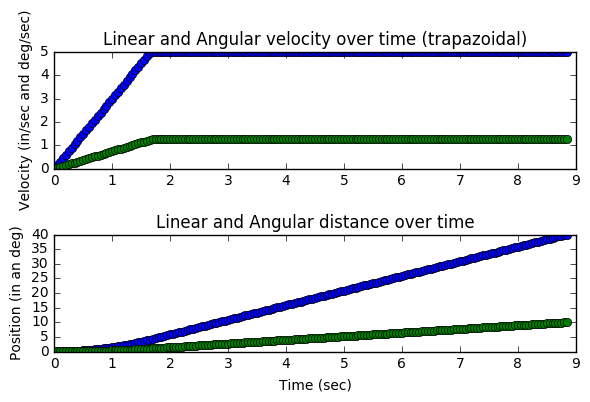







Linear distance is Negative
Angle is Negative
Acceleration max is 3
Max velocity is 5
Will not halt at end of profile
Will start with zero velocity
ProfileParams(distance=-40, angle=10, max_velocity=5, max_acceleration=3, halt=False, rampup=True)
rampup dist:  -4.166666666666667
0.0 1.6666666666666667 8.833333333333334 8.833333333333334
5


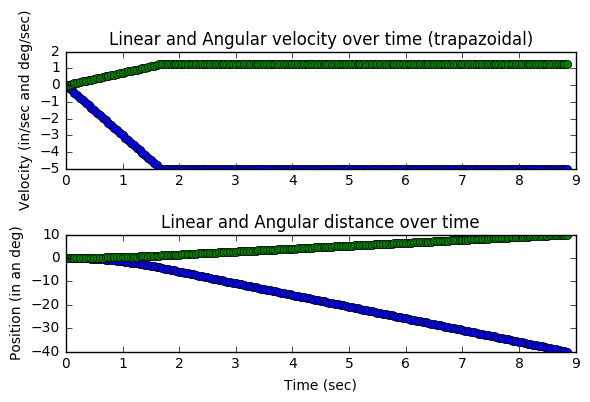







Linear distance is Positive
Angle is Positive
Acceleration max is 3
Max velocity is 5
Will not halt at end of profile
Will start with zero velocity
ProfileParams(distance=40, angle=0, max_velocity=5, max_acceleration=3, halt=False, rampup=True)
rampup dist:  4.166666666666667
0.0 1.6666666666666667 8.833333333333334 8.833333333333334
5


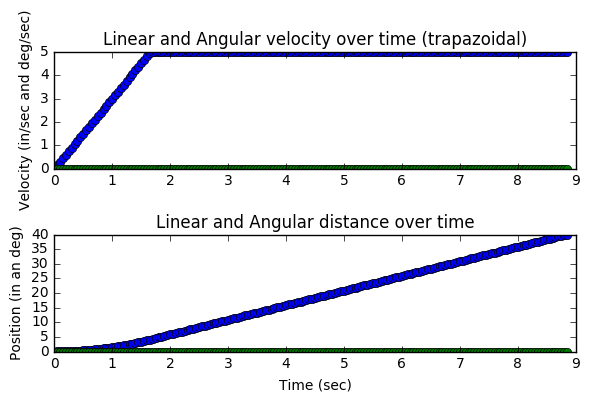







Linear distance is Negative
Angle is Negative
Acceleration max is 3
Max velocity is 5
Will not halt at end of profile
Will start with zero velocity
ProfileParams(distance=-40, angle=0, max_velocity=5, max_acceleration=3, halt=False, rampup=True)
rampup dist:  -4.166666666666667
0.0 1.6666666666666667 8.833333333333334 8.833333333333334
5


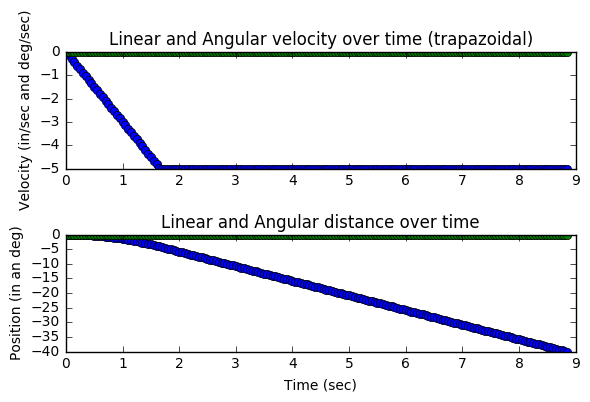







Linear distance is Positive
Angle is Positive
Acceleration max is 3
Max velocity is 5
Will not halt at end of profile
Will start with zero velocity
ProfileParams(distance=40, angle=-10, max_velocity=5, max_acceleration=3, halt=False, rampup=True)
rampup dist:  4.166666666666667
0.0 1.6666666666666667 8.833333333333334 8.833333333333334
5


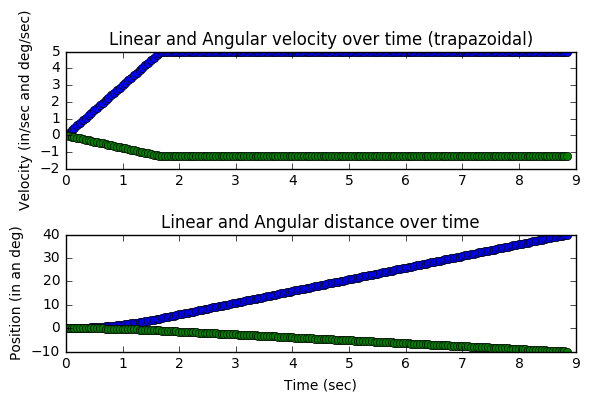







Linear distance is Negative
Angle is Negative
Acceleration max is 3
Max velocity is 5
Will not halt at end of profile
Will start with zero velocity
ProfileParams(distance=-40, angle=-10, max_velocity=5, max_acceleration=3, halt=False, rampup=True)
rampup dist:  -4.166666666666667
0.0 1.6666666666666667 8.833333333333334 8.833333333333334
5


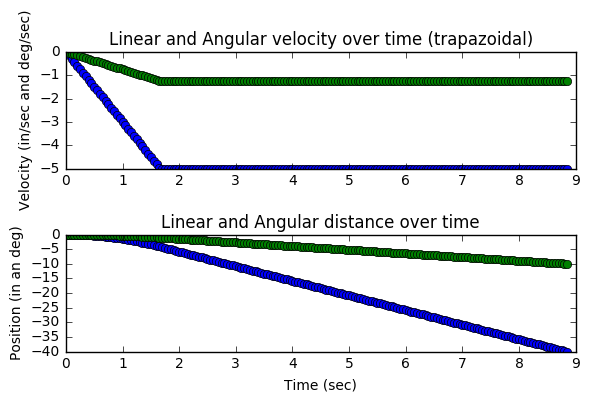







Linear distance is Positive
Angle is Positive
Acceleration max is 3
Max velocity is 50
Will not halt at end of profile
Will start with zero velocity
ProfileParams(distance=40, angle=10, max_velocity=50, max_acceleration=3, halt=False, rampup=True)
rampup dist:  416.6666666666667
0.0 5.163977794943222 5.163977794943222 5.163977794943222
15.491933384829668


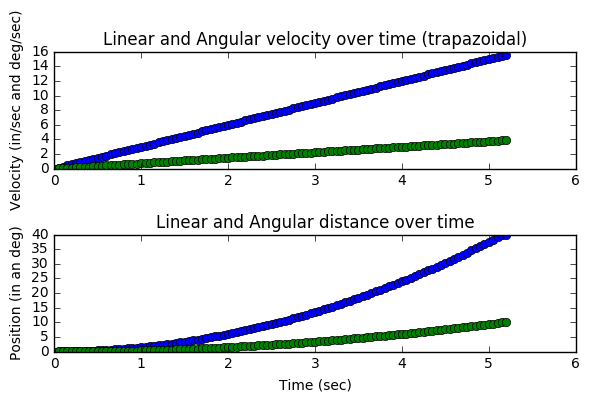







Linear distance is Negative
Angle is Negative
Acceleration max is 3
Max velocity is 50
Will not halt at end of profile
Will start with zero velocity
ProfileParams(distance=-40, angle=10, max_velocity=50, max_acceleration=3, halt=False, rampup=True)
rampup dist:  -416.6666666666667
0.0 5.163977794943222 5.163977794943222 5.163977794943222
15.491933384829668


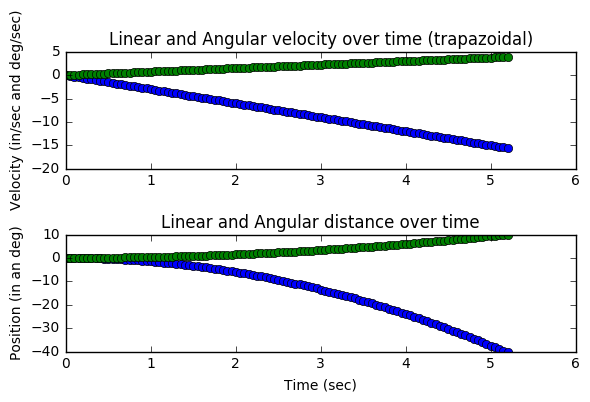







Linear distance is Positive
Angle is Positive
Acceleration max is 3
Max velocity is 50
Will not halt at end of profile
Will start with zero velocity
ProfileParams(distance=40, angle=0, max_velocity=50, max_acceleration=3, halt=False, rampup=True)
rampup dist:  416.6666666666667
0.0 5.163977794943222 5.163977794943222 5.163977794943222
15.491933384829668


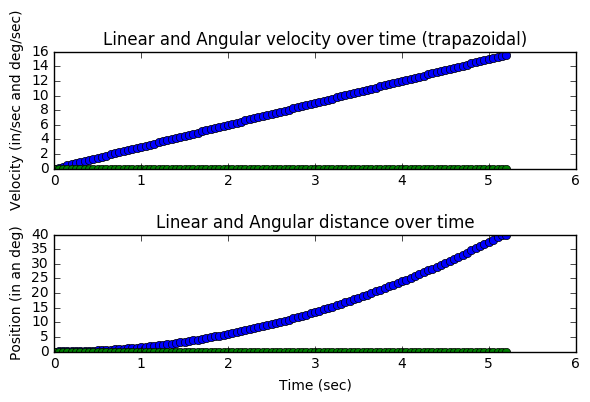







Linear distance is Negative
Angle is Negative
Acceleration max is 3
Max velocity is 50
Will not halt at end of profile
Will start with zero velocity
ProfileParams(distance=-40, angle=0, max_velocity=50, max_acceleration=3, halt=False, rampup=True)
rampup dist:  -416.6666666666667
0.0 5.163977794943222 5.163977794943222 5.163977794943222
15.491933384829668


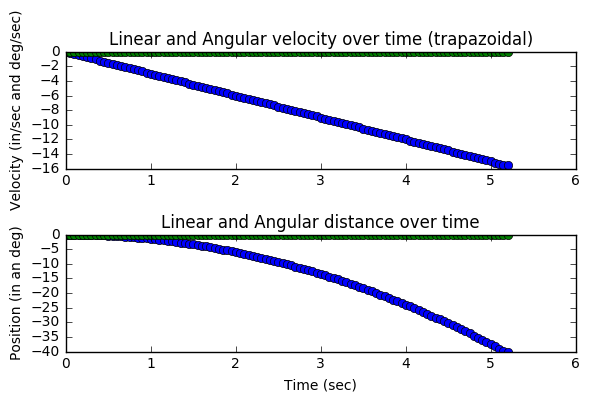







Linear distance is Positive
Angle is Positive
Acceleration max is 3
Max velocity is 50
Will not halt at end of profile
Will start with zero velocity
ProfileParams(distance=40, angle=-10, max_velocity=50, max_acceleration=3, halt=False, rampup=True)
rampup dist:  416.6666666666667
0.0 5.163977794943222 5.163977794943222 5.163977794943222
15.491933384829668


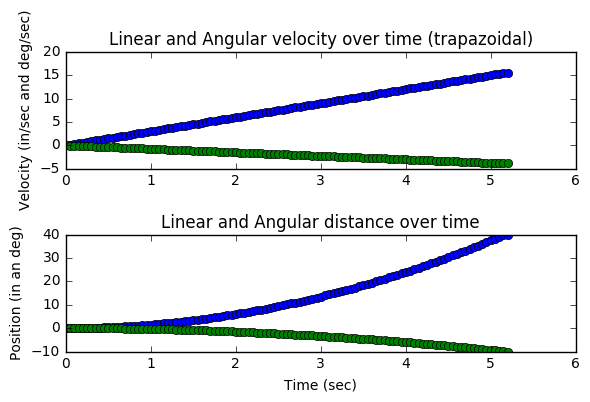







Linear distance is Negative
Angle is Negative
Acceleration max is 3
Max velocity is 50
Will not halt at end of profile
Will start with zero velocity
ProfileParams(distance=-40, angle=-10, max_velocity=50, max_acceleration=3, halt=False, rampup=True)
rampup dist:  -416.6666666666667
0.0 5.163977794943222 5.163977794943222 5.163977794943222
15.491933384829668


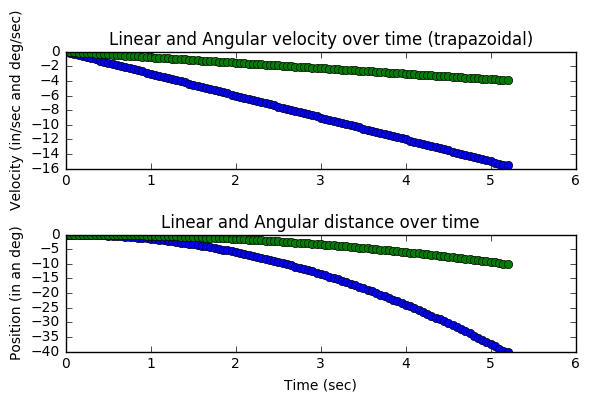







Linear distance is Positive
Angle is Positive
Acceleration max is 3
Max velocity is 5
Will halt at end of profile
Will not start with zero velocity
ProfileParams(distance=40, angle=10, max_velocity=5, max_acceleration=3, halt=True, rampup=False)
rampup dist:  4.166666666666667
0.0 0.0 7.166666666666667 8.833333333333334


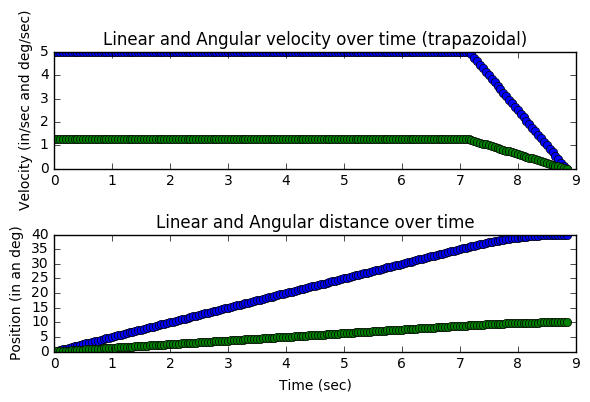







Linear distance is Negative
Angle is Negative
Acceleration max is 3
Max velocity is 5
Will halt at end of profile
Will not start with zero velocity
ProfileParams(distance=-40, angle=10, max_velocity=5, max_acceleration=3, halt=True, rampup=False)
rampup dist:  -4.166666666666667
0.0 0.0 7.166666666666667 8.833333333333334


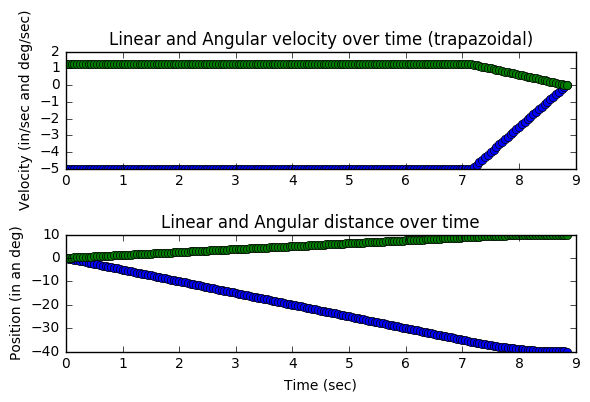







Linear distance is Positive
Angle is Positive
Acceleration max is 3
Max velocity is 5
Will halt at end of profile
Will not start with zero velocity
ProfileParams(distance=40, angle=0, max_velocity=5, max_acceleration=3, halt=True, rampup=False)
rampup dist:  4.166666666666667
0.0 0.0 7.166666666666667 8.833333333333334


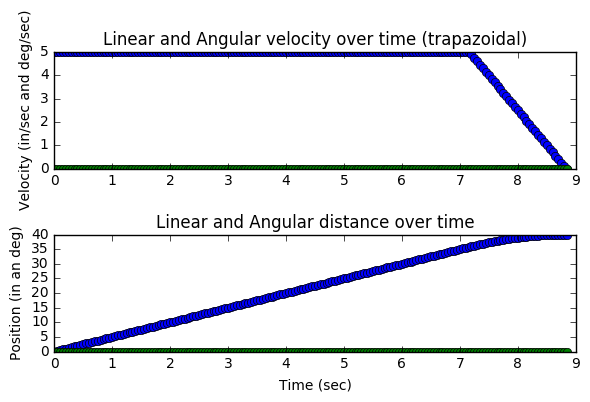







Linear distance is Negative
Angle is Negative
Acceleration max is 3
Max velocity is 5
Will halt at end of profile
Will not start with zero velocity
ProfileParams(distance=-40, angle=0, max_velocity=5, max_acceleration=3, halt=True, rampup=False)
rampup dist:  -4.166666666666667
0.0 0.0 7.166666666666667 8.833333333333334


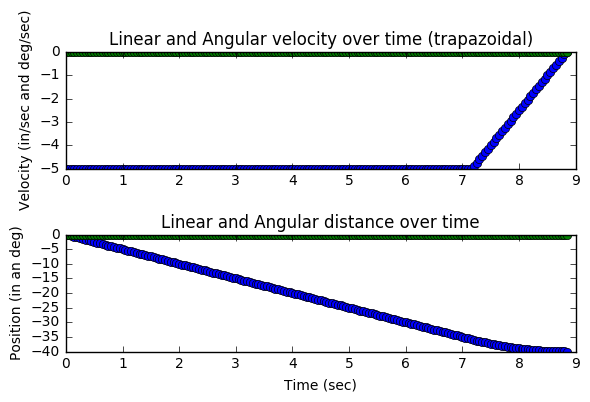







Linear distance is Positive
Angle is Positive
Acceleration max is 3
Max velocity is 5
Will halt at end of profile
Will not start with zero velocity
ProfileParams(distance=40, angle=-10, max_velocity=5, max_acceleration=3, halt=True, rampup=False)
rampup dist:  4.166666666666667
0.0 0.0 7.166666666666667 8.833333333333334


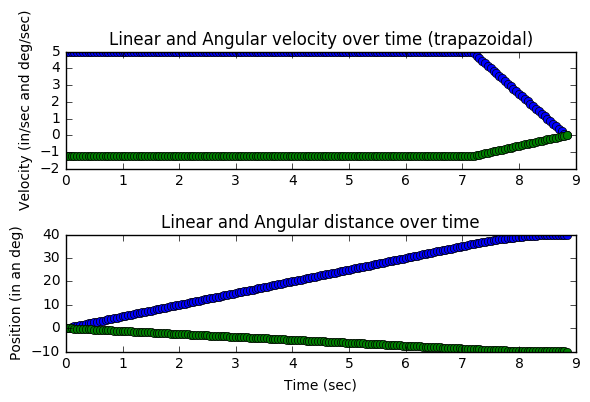







Linear distance is Negative
Angle is Negative
Acceleration max is 3
Max velocity is 5
Will halt at end of profile
Will not start with zero velocity
ProfileParams(distance=-40, angle=-10, max_velocity=5, max_acceleration=3, halt=True, rampup=False)
rampup dist:  -4.166666666666667
0.0 0.0 7.166666666666667 8.833333333333334


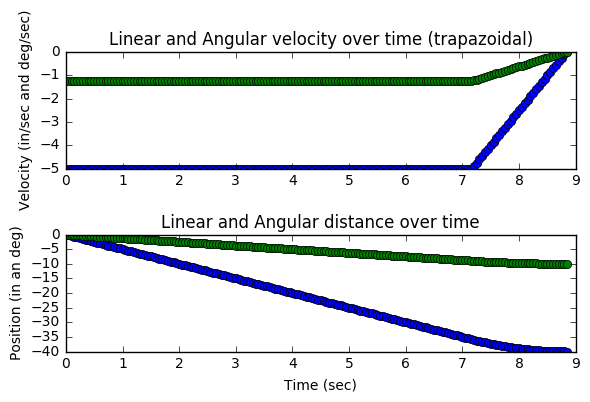







Linear distance is Positive
Angle is Positive
Acceleration max is 3
Max velocity is 50
Will halt at end of profile
Will not start with zero velocity
ProfileParams(distance=40, angle=10, max_velocity=50, max_acceleration=3, halt=True, rampup=False)
rampup dist:  416.6666666666667


Profile is impossible (lib handled correctly)






Linear distance is Negative
Angle is Negative
Acceleration max is 3
Max velocity is 50
Will halt at end of profile
Will not start with zero velocity
ProfileParams(distance=-40, angle=10, max_velocity=50, max_acceleration=3, halt=True, rampup=False)
rampup dist:  -416.6666666666667


Profile is impossible (lib handled correctly)






Linear distance is Positive
Angle is Positive
Acceleration max is 3
Max velocity is 50
Will halt at end of profile
Will not start with zero velocity
ProfileParams(distance=40, angle=0, max_velocity=50, max_acceleration=3, halt=True, rampup=False)
rampup dist:  416.6666666666667


Profile is impossible (lib handled correctl

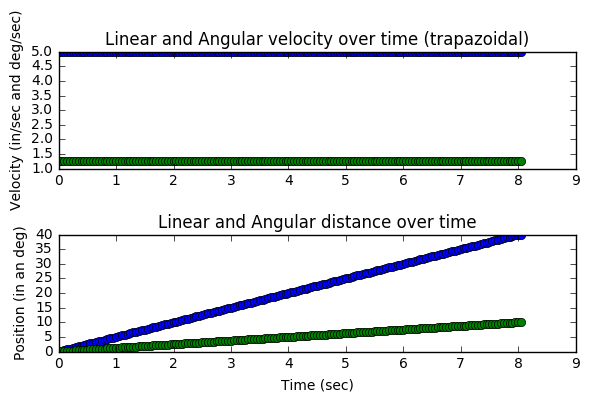







Linear distance is Negative
Angle is Negative
Acceleration max is 3
Max velocity is 5
Will not halt at end of profile
Will not start with zero velocity
ProfileParams(distance=-40, angle=10, max_velocity=5, max_acceleration=3, halt=False, rampup=False)
rampup dist:  -4.166666666666667
0.0 0.0 8.0 8.0
5


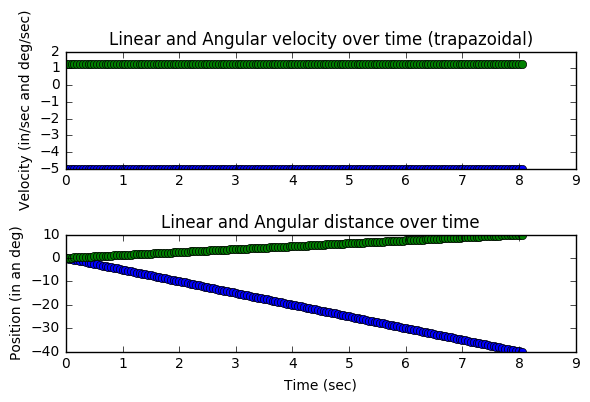







Linear distance is Positive
Angle is Positive
Acceleration max is 3
Max velocity is 5
Will not halt at end of profile
Will not start with zero velocity
ProfileParams(distance=40, angle=0, max_velocity=5, max_acceleration=3, halt=False, rampup=False)
rampup dist:  4.166666666666667
0.0 0.0 8.0 8.0
5


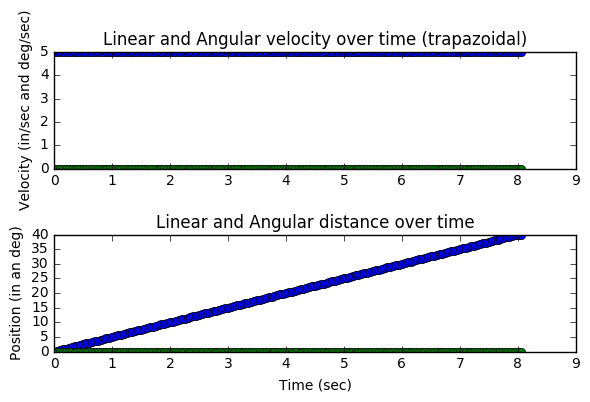







Linear distance is Negative
Angle is Negative
Acceleration max is 3
Max velocity is 5
Will not halt at end of profile
Will not start with zero velocity
ProfileParams(distance=-40, angle=0, max_velocity=5, max_acceleration=3, halt=False, rampup=False)
rampup dist:  -4.166666666666667
0.0 0.0 8.0 8.0
5


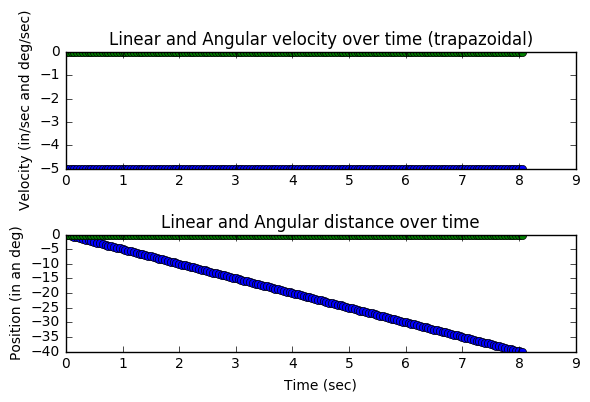







Linear distance is Positive
Angle is Positive
Acceleration max is 3
Max velocity is 5
Will not halt at end of profile
Will not start with zero velocity
ProfileParams(distance=40, angle=-10, max_velocity=5, max_acceleration=3, halt=False, rampup=False)
rampup dist:  4.166666666666667
0.0 0.0 8.0 8.0
5


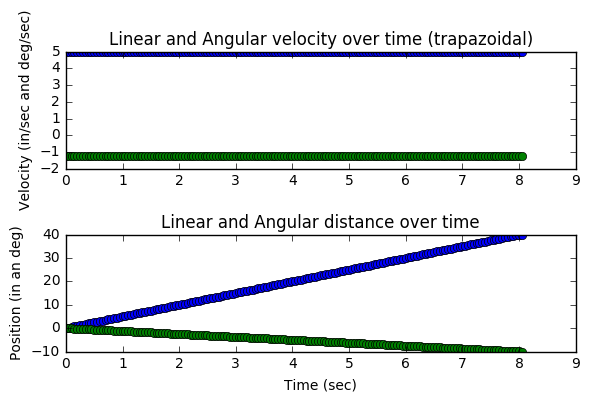







Linear distance is Negative
Angle is Negative
Acceleration max is 3
Max velocity is 5
Will not halt at end of profile
Will not start with zero velocity
ProfileParams(distance=-40, angle=-10, max_velocity=5, max_acceleration=3, halt=False, rampup=False)
rampup dist:  -4.166666666666667
0.0 0.0 8.0 8.0
5


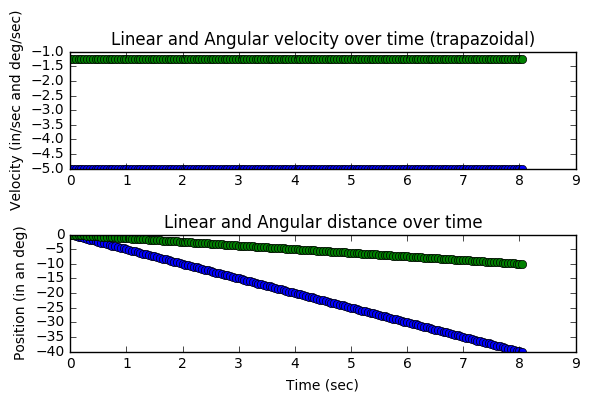







Linear distance is Positive
Angle is Positive
Acceleration max is 3
Max velocity is 50
Will not halt at end of profile
Will not start with zero velocity
ProfileParams(distance=40, angle=10, max_velocity=50, max_acceleration=3, halt=False, rampup=False)
rampup dist:  416.6666666666667
0.0 0.0 0.8 0.8
50


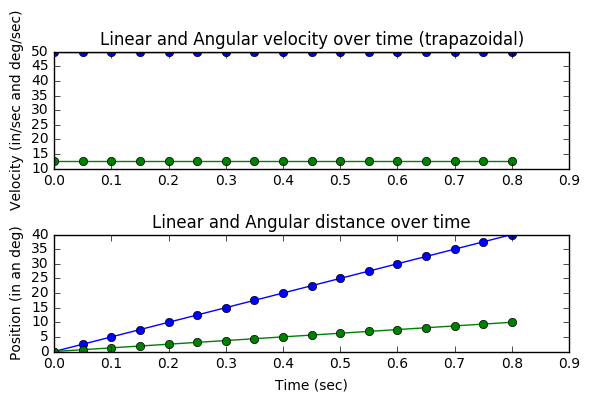







Linear distance is Negative
Angle is Negative
Acceleration max is 3
Max velocity is 50
Will not halt at end of profile
Will not start with zero velocity
ProfileParams(distance=-40, angle=10, max_velocity=50, max_acceleration=3, halt=False, rampup=False)
rampup dist:  -416.6666666666667
0.0 0.0 0.8 0.8
50


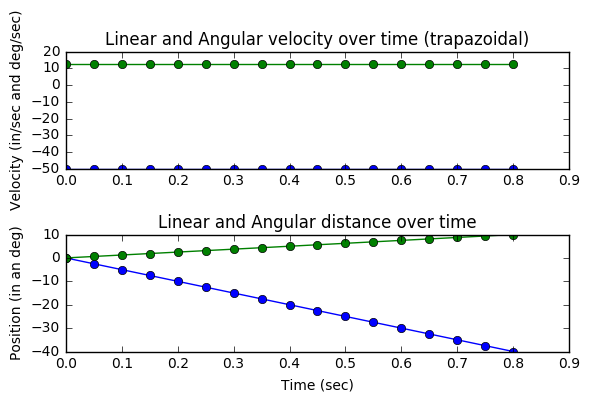







Linear distance is Positive
Angle is Positive
Acceleration max is 3
Max velocity is 50
Will not halt at end of profile
Will not start with zero velocity
ProfileParams(distance=40, angle=0, max_velocity=50, max_acceleration=3, halt=False, rampup=False)
rampup dist:  416.6666666666667
0.0 0.0 0.8 0.8
50


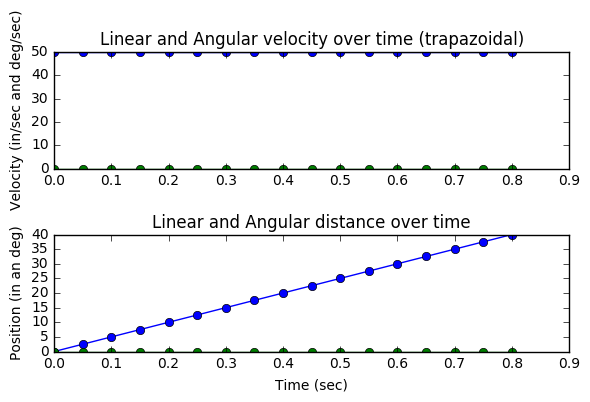







Linear distance is Negative
Angle is Negative
Acceleration max is 3
Max velocity is 50
Will not halt at end of profile
Will not start with zero velocity
ProfileParams(distance=-40, angle=0, max_velocity=50, max_acceleration=3, halt=False, rampup=False)
rampup dist:  -416.6666666666667
0.0 0.0 0.8 0.8
50


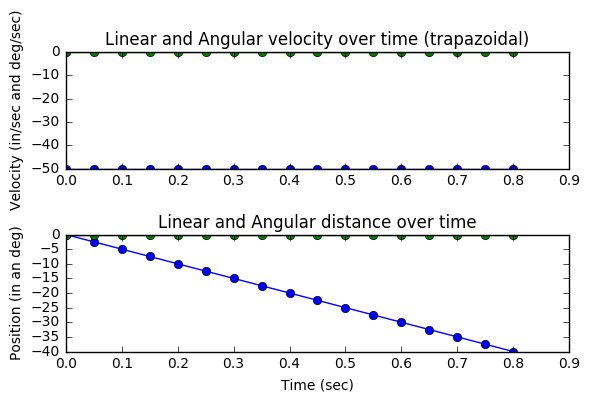







Linear distance is Positive
Angle is Positive
Acceleration max is 3
Max velocity is 50
Will not halt at end of profile
Will not start with zero velocity
ProfileParams(distance=40, angle=-10, max_velocity=50, max_acceleration=3, halt=False, rampup=False)
rampup dist:  416.6666666666667
0.0 0.0 0.8 0.8
50


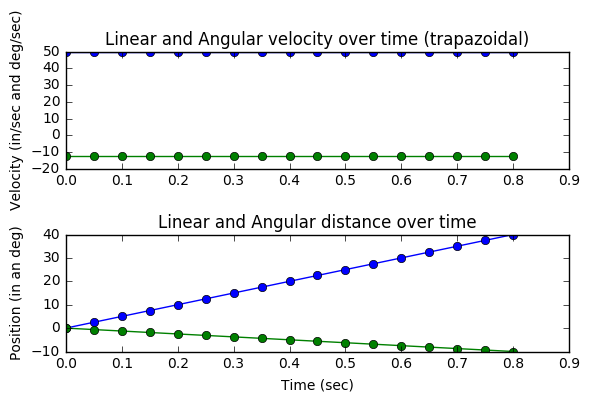







Linear distance is Negative
Angle is Negative
Acceleration max is 3
Max velocity is 50
Will not halt at end of profile
Will not start with zero velocity
ProfileParams(distance=-40, angle=-10, max_velocity=50, max_acceleration=3, halt=False, rampup=False)
rampup dist:  -416.6666666666667
0.0 0.0 0.8 0.8
50


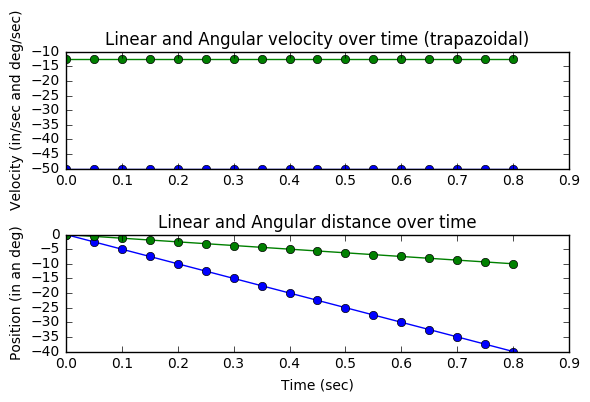

In [9]:
"""
Try all combinations of edge cases
"""

for rampup in [True, False]:
    for halt in [True, False]:
        for v_max in [5, 50]:
            for a_max in [3]:
                for angle in [10, 0, -10]:
                    for dist in [40, -40]:
                        print("Linear distance is", ["Zero", "Positive", "Negative"][signum(dist)])
                        print("Angle is", ["Zero", "Positive", "Negative"][signum(dist)])
                        print("Acceleration max is", a_max)
                        print("Max velocity is", v_max)
                        print("Will" if halt else "Will not", "halt at end of profile")
                        print("Will" if rampup else "Will not", "start with zero velocity")
                        params = ProfileParams(dist, angle, v_max, a_max, halt, rampup)
                        print(params)
                        try:
                            test_gen_profile(params)
                        except ImpossibleProfileException as e:
                            assert_profile_impossible(params)
                            print("\n\nProfile is impossible (lib handled correctly)")
                        print("\n\n\n\n\n")